# **📓 02: Entrenamiento y Evaluación de Modelos**

Este notebook es el motor del pipeline de MLOps. Su función es tomar los datasets organizados por el script `01_Preprocesamiento` y ejecutar ciclos de entrenamiento de forma automatizada, basándose en las tareas definidas en la "Hoja de Experimentos".

**Flujo de Trabajo:**
1.  **Conexión y Configuración:** Se conecta a Google Drive y a la Hoja de Experimentos.
2.  **Selección de Tarea:** Busca y carga la próxima tarea de entrenamiento con estado `PENDIENTE`.
3.  **Carga de Datos:** Carga las imágenes de la fuente especificada (`propio`, `externo` o `mixto`).
4.  **Construcción del Modelo:** Define la arquitectura del modelo usando Transfer Learning.
5.  **Entrenamiento:** Compila y entrena el modelo, guardando la mejor versión (`ModelCheckpoint`).
6.  **Evaluación:** Genera un conjunto completo de métricas y visualizaciones.
7.  **Registro de Resultados:** Actualiza la Hoja de Experimentos con el estado `COMPLETADO` y los resultados obtenidos.

### **Configuración del Entorno y Conexión**

Esta celda inicial se encarga de toda la preparación necesaria para ejecutar el pipeline de entrenamiento. Realiza las siguientes tareas en orden:

1.  **Montar Google Drive:** Conecta el sistema de archivos de tu Google Drive.
2.  **Localizar el Proyecto:** Busca dinámicamente la carpeta raíz del proyecto.
3.  **Instalar Dependencias:** Instala todas las librerías desde el archivo `requirements.txt`.
4.  **Importar Librerías y Configuración:** Importa los módulos de Python y las variables personalizadas (nombres de hojas, timezone) desde tu archivo `config.py`.
5.  **Autenticar:** Solicita los permisos para que el script pueda leer y escribir en tu Hoja de Experimentos.
6.  **Definir Rutas:** Construye todas las rutas a los directorios de datos.

In [1]:
# ====================================================================================
# @title PASO 1: SETUP, CONFIGURACIÓN Y CONEXIÓN
# ====================================================================================
import os
import sys

# --- 1. Montar Google Drive ---
if not os.path.exists('/content/drive/MyDrive'):
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Google Drive ya está montado.")

# --- 2. Búsqueda Dinámica de la Ruta Base del Proyecto ---
NOMBRE_CARPETA_ANCLA = 'Proyecto_VIREC'
RUTA_BASE_PROYECTO = None
print(f"\nBuscando la carpeta ancla '{NOMBRE_CARPETA_ANCLA}'...")
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    if NOMBRE_CARPETA_ANCLA in dirs:
        RUTA_BASE_PROYECTO = os.path.join(root, NOMBRE_CARPETA_ANCLA)
        break

if not RUTA_BASE_PROYECTO:
    raise FileNotFoundError(f"❌ ERROR CRÍTICO: No se pudo encontrar la carpeta '{NOMBRE_CARPETA_ANCLA}'.")
else:
    print(f"✅ ¡Proyecto encontrado! La ruta base es: {RUTA_BASE_PROYECTO}")

    # --- 3. Instalar Dependencias desde requirements.txt ---
    ruta_requirements = os.path.join(RUTA_BASE_PROYECTO, 'requirements.txt')
    if os.path.exists(ruta_requirements):
        print("\nInstalando dependencias...")
        !pip install -r "{ruta_requirements}" -q
        print("✅ Dependencias instaladas.")
    else:
        raise FileNotFoundError(f"❌ ERROR: No se encontró 'requirements.txt'.")

# --- 4. Importar Librerías ---
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gspread
import pytz
from datetime import datetime
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from google.colab import auth
from google.auth import default

# --- 5. Importar la Configuración del Usuario ---
sys.path.append(RUTA_BASE_PROYECTO)
try:
    from config import NOMBRE_HOJA_EXPERIMENTOS, TIMEZONE, CLASES_MODELO
    print("✅ Configuración local importada desde config.py.")
except ImportError:
    raise ImportError("❌ ERROR: No se encontró 'config.py'. Revisa la plantilla.")

# --- 6. Autenticación con Google Sheets ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticación con Google Sheets exitosa.")
except Exception as e:
    print(f"⚠️ Advertencia: No se pudo autenticar con Google Sheets. Error: {e}")

# --- 7. Construcción Final de Rutas y Conexión a la Hoja ---
RUTA_DATASET_PROPIO = os.path.join(RUTA_BASE_PROYECTO, 'dataset', 'dataset_final_propio')
RUTA_DATASET_EXTERNO = os.path.join(RUTA_BASE_PROYECTO, 'dataset', 'dataset_final_externo')
RUTA_MODELOS = os.path.join(RUTA_BASE_PROYECTO, 'modelos_entrenados')

NOMBRE_PESTANA_EXPERIMENTOS = "Experimentos"
try:
    hoja_experimentos = gc.open(NOMBRE_HOJA_EXPERIMENTOS).worksheet(NOMBRE_PESTANA_EXPERIMENTOS)
    print(f"✅ Conexión exitosa a la Hoja de Experimentos: '{NOMBRE_HOJA_EXPERIMENTOS}'")
except Exception as e:
    hoja_experimentos = None
    print(f"❌ ERROR: No se pudo conectar a la Hoja de Experimentos. El script no podrá actualizar los resultados. Error: {e}")

print("\nTensorFlow Version:", tf.__version__)
print("\n✅ Entorno completamente configurado.")

Google Drive ya está montado.

Buscando la carpeta ancla 'Proyecto_VIREC'...
✅ ¡Proyecto encontrado! La ruta base es: /content/drive/MyDrive/Colab Notebooks/TalentoTech/Proyecto_VIREC

Instalando dependencias...
✅ Dependencias instaladas.
✅ Configuración local importada desde config.py.
✅ Autenticación con Google Sheets exitosa.
✅ Conexión exitosa a la Hoja de Experimentos: 'VIREC - Hoja de Experimentos'

TensorFlow Version: 2.19.0

✅ Entorno completamente configurado.


### **Funciones de Utilidad del Pipeline**
Esta celda contiene las funciones principales que definen el flujo de trabajo de un experimento. Se han separado para mejorar la legibilidad y la reutilización del código.

In [2]:
# ====================================================================================
# @title PASO 2: FUNCIONES DE UTILIDAD DEL PIPELINE
# ====================================================================================

def cargar_proxima_tarea(hoja_experimentos):
    """
    Lee la hoja de experimentos, encuentra la primera tarea 'PENDIENTE'
    y devuelve la información de la tarea y el número de fila a actualizar.
    """
    print("Buscando próxima tarea pendiente en la Hoja de Experimentos...")
    try:
        valores_crudos = hoja_experimentos.get_all_values()
        df_experimentos = pd.DataFrame(valores_crudos[1:], columns=valores_crudos[0])

        tareas_pendientes = df_experimentos[df_experimentos['status'].str.strip().str.upper() == 'PENDIENTE']

        if tareas_pendientes.empty:
            print("✅ No se encontraron experimentos pendientes.")
            return None, -1, None

        siguiente_tarea = tareas_pendientes.iloc[0]
        fila_a_actualizar = siguiente_tarea.name + 2

        print(f"-> Tarea encontrada: '{siguiente_tarea['experiment_id']}' en la fila {fila_a_actualizar}.")
        return siguiente_tarea, fila_a_actualizar, df_experimentos.columns.tolist()

    except Exception as e:
        print(f"❌ ERROR al leer la Hoja de Experimentos: {e}")
        return None, -1, None

def cargar_datasets(dataset_source, img_size, batch_size, color_mode):
    """
    Carga los datasets de entrenamiento, validación y prueba según la fuente especificada.
    """
    print(f"Cargando datos para la fuente: '{dataset_source}'...")

    def cargar_split(ruta_fuente, split_name):
        ruta_split = os.path.join(ruta_fuente, split_name)
        if not os.path.exists(ruta_split) or not os.listdir(ruta_split): return None
        return tf.keras.utils.image_dataset_from_directory(
            ruta_split, labels='inferred', label_mode='binary',
            image_size=img_size, batch_size=batch_size, color_mode=color_mode,
            shuffle=(split_name == 'train')
        )

    if dataset_source == 'propio':
        train_ds = cargar_split(RUTA_DATASET_PROPIO, 'train')
        val_ds = cargar_split(RUTA_DATASET_PROPIO, 'validation')
        test_ds = cargar_split(RUTA_DATASET_PROPIO, 'test')
    elif dataset_source == 'externo':
        train_ds = cargar_split(RUTA_DATASET_EXTERNO, 'train')
        val_ds = cargar_split(RUTA_DATASET_EXTERNO, 'validation')
        test_ds = cargar_split(RUTA_DATASET_EXTERNO, 'test')
    elif dataset_source == 'mixto':
        train_p = cargar_split(RUTA_DATASET_PROPIO, 'train')
        val_p = cargar_split(RUTA_DATASET_PROPIO, 'validation')
        test_p = cargar_split(RUTA_DATASET_PROPIO, 'test')
        train_e = cargar_split(RUTA_DATASET_EXTERNO, 'train')
        val_e = cargar_split(RUTA_DATASET_EXTERNO, 'validation')
        test_e = cargar_split(RUTA_DATASET_EXTERNO, 'test')

        train_ds = train_p.concatenate(train_e) if train_p and train_e else (train_p or train_e)
        val_ds = val_p.concatenate(val_e) if val_p and val_e else (val_p or val_e)
        test_ds = test_p.concatenate(test_e) if test_p and test_e else (test_p or test_e)
    else:
        raise ValueError(f"Fuente de datos '{dataset_source}' no reconocida.")

    if train_ds is None:
        raise FileNotFoundError(f"No se pudieron cargar datos de entrenamiento para la fuente '{dataset_source}'.")

    # 1. Capturamos los nombres de las clases ANTES de optimizar el dataset.
    # Usamos CLASES_MODELO de config.py como respaldo si no se pueden obtener.
    try:
        class_names = train_ds.class_names
    except AttributeError:
        print("Advertencia: No se pudo obtener 'class_names' del dataset. Usando la configuración de config.py.")
        class_names = CLASES_MODELO

    # 2. Optimización del pipeline (sin cambios)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    if val_ds: val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    if test_ds: test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    # 3. Devolvemos los 4 valores que la celda de ejecución espera
    return train_ds, val_ds, test_ds, class_names

def construir_modelo(img_size, channels, use_augmentation, modelo_base_nombre):
    """
    Construye el modelo de Transfer Learning, seleccionando dinámicamente
    la arquitectura base.
    """
    print(f"\nConstruyendo la arquitectura del modelo con base: '{modelo_base_nombre}'...")

    # Capas de preprocesamiento
    rescale_layer = layers.Rescaling(1./255)
    data_augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="data_augmentation")

    # --- LÓGICA DE SELECCIÓN DEL MODELO BASE ---
    pesos_imagenet = 'imagenet' if channels == 3 else None

    if modelo_base_nombre.lower() == 'mobilenetv2':
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=(img_size[0], img_size[1], channels),
            include_top=False,
            weights=pesos_imagenet
        )
    elif modelo_base_nombre.lower() == 'resnet50':
        # Ejemplo de cómo podrías añadir otro modelo en el futuro
        base_model = tf.keras.applications.ResNet50(
            input_shape=(img_size[0], img_size[1], channels),
            include_top=False,
            weights=pesos_imagenet
        )
    else:
        raise ValueError(f"Modelo base '{modelo_base_nombre}' no reconocido. Opciones válidas: 'MobileNetV2', 'ResNet50', etc.")

    base_model.trainable = False

    # Construir el pipeline de capas
    inputs = keras.Input(shape=(img_size[0], img_size[1], channels))
    x = inputs
    if use_augmentation:
        x = data_augmentation(x)
    x = rescale_layer(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)

    print("✅ Modelo construido exitosamente.")
    if pesos_imagenet:
        print(f"   -> Se utilizaron los pesos pre-entrenados de ImageNet para {modelo_base_nombre}.")
    else:
        print(f"   -> El modelo {modelo_base_nombre} se inicializó con pesos aleatorios.")

    return model

def entrenar_modelo(model, train_ds, val_ds, epochs, learning_rate, checkpoint_path):
    """
    Compila y entrena el modelo, guardando la mejor versión.
    """
    print("\nCompilando y preparando el entrenamiento...")

    # Compilar el modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    # --- Preparar los callbacks y argumentos ---
    fit_kwargs = {'epochs': epochs}

    # Si hay datos de validación, configuramos el checkpoint para monitorearlos
    if val_ds:
        monitor_metric = 'val_accuracy'
        monitor_mode = 'max'
        fit_kwargs['validation_data'] = val_ds
    # Si no, monitoreamos la pérdida de entrenamiento
    else:
        print("\n⚠️ ADVERTENCIA: No se encontraron datos de validación.")
        print("   El ModelCheckpoint guardará el modelo con la menor pérdida de entrenamiento ('loss').")
        monitor_metric = 'loss'
        monitor_mode = 'min'

    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=False,
        monitor=monitor_metric,
        mode=monitor_mode,
        save_best_only=True,
        verbose=1
    )
    fit_kwargs['callbacks'] = [model_checkpoint_callback]

    # --- Iniciar el entrenamiento ---
    print(f"\nIniciando entrenamiento por {epochs} épocas...")
    history = model.fit(
        train_ds,
        **fit_kwargs
    )
    print("\n✅ Entrenamiento completado.")
    return history

def evaluar_y_registrar(history, test_ds, checkpoint_path, experiment_id, class_names):
    """
    Evalúa el mejor modelo guardado, genera TODAS las visualizaciones (incluyendo análisis de errores),
    y devuelve un diccionario con las métricas finales.
    """
    print("\n" + "-"*70)
    print("INICIANDO FASE DE EVALUACIÓN Y REGISTRO")
    print("-"*70)

    # 1. Cargar el mejor modelo guardado
    if not os.path.exists(checkpoint_path):
        print(f"❌ ERROR: No se encontró el modelo guardado. Saltando evaluación.")
        return {}
    best_model = keras.models.load_model(checkpoint_path)

    # 2. Definir paleta de colores y estilo
    PALETA_COLORES = {"primario": "#3E8160", "secundario": "#A2D183", "acento": "#8AE2F8", "texto": "#312829"}
    plt.style.use('default')

    # 3. Visualizar y guardar curvas de aprendizaje
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(len(acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle(f'Resultados del Entrenamiento: {experiment_id}', fontsize=20, weight='bold', color=PALETA_COLORES['texto'])

    ax1.plot(epochs_range, acc, 'o-', label='Entrenamiento', color=PALETA_COLORES['primario'], linewidth=2)
    if val_acc:
        ax1.plot(epochs_range, val_acc, 's--', label='Validación', color=PALETA_COLORES['acento'], linewidth=2)
        best_epoch = np.argmax(val_acc)
        best_acc_val = val_acc[best_epoch]
        ax1.axvline(x=best_epoch, color='gray', linestyle=':', linewidth=1.5, label=f'Mejor Época ({best_epoch+1})')
        ax1.annotate(f'{best_acc_val:.3f}', xy=(best_epoch, best_acc_val), xytext=(best_epoch, best_acc_val + 0.01), ha='center', color=PALETA_COLORES['primario'], weight='bold')
    ax1.set_title('Precisión (Accuracy) por Época', fontsize=16)
    ax1.set_xlabel('Época', fontsize=12)
    ax1.set_ylabel('Precisión', fontsize=12)
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax2.plot(epochs_range, loss, 'o-', label='Entrenamiento', color=PALETA_COLORES['primario'], linewidth=2)
    if val_loss:
        ax2.plot(epochs_range, val_loss, 's--', label='Validación', color=PALETA_COLORES['acento'], linewidth=2)
        best_epoch_loss = np.argmin(val_loss)
        best_loss_val = val_loss[best_epoch_loss]
        ax2.axvline(x=best_epoch_loss, color='gray', linestyle=':', linewidth=1.5, label=f'Mejor Época ({best_epoch_loss+1})')
        ax2.annotate(f'{best_loss_val:.3f}', xy=(best_epoch_loss, best_loss_val), xytext=(best_epoch_loss, best_loss_val + 0.02), ha='center', color=PALETA_COLORES['primario'], weight='bold')
    ax2.set_title('Pérdida (Loss) por Época', fontsize=16)
    ax2.set_xlabel('Época', fontsize=12)
    ax2.set_ylabel('Pérdida', fontsize=12)
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    ruta_grafica_aprendizaje = os.path.join(RUTA_RESULTADOS_EXPERIMENTO, 'curvas_de_aprendizaje.png')
    plt.savefig(ruta_grafica_aprendizaje, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Gráfica de curvas de aprendizaje guardada en: {ruta_grafica_aprendizaje}")

    # 4. Evaluar en el conjunto de prueba
    resultados_finales = {}
    if test_ds:
        print("\nEvaluando modelo con el conjunto de prueba...")
        test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
        resultados_finales['test_accuracy'] = test_acc
        resultados_finales['test_loss'] = test_loss
        print(f'  -> Precisión (Accuracy) en Prueba: {test_acc:.2%}')

        # --- INICIO DE LA LÓGICA INTEGRADA DE ANÁLISIS DE ERRORES ---
        print("\nAnalizando errores del modelo...")
        all_images, all_labels, all_predictions, all_pred_probs = [], [], [], []
        for images, labels in test_ds:
            all_images.extend(images.numpy())
            all_labels.extend(labels.numpy().flatten().astype(int))
            preds = best_model.predict(images, verbose=0)
            all_pred_probs.extend(preds.flatten())
            all_predictions.extend((preds.flatten() > 0.5).astype(int))

        y_true = np.array(all_labels)
        y_pred = np.array(all_predictions)

        # Reporte de Clasificación
        print("\n--- Reporte de Clasificación ---")
        print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
        report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

        resultados_finales['test_precision'] = report_dict.get(class_names[1], {}).get('precision')
        resultados_finales['test_recall'] = report_dict.get(class_names[1], {}).get('recall')
        resultados_finales['test_f1_score'] = report_dict.get(class_names[1], {}).get('f1-score')

        # Matriz de Confusión y Curva ROC
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle(f'Análisis de Rendimiento en Prueba: {experiment_id}', fontsize=20, weight='bold', color=PALETA_COLORES['texto'])
        cm = confusion_matrix(y_true, y_pred)
        cmap_personalizado = sns.light_palette(PALETA_COLORES['secundario'], as_cmap=True)
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_personalizado, ax=ax1, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 16, "weight": "bold"}, cbar=False)
        ax1.set_title('Matriz de Confusión', fontsize=16)
        ax1.set_xlabel('Predicción', fontsize=12)
        ax1.set_ylabel('Etiqueta Real', fontsize=12)

        fpr, tpr, _ = roc_curve(y_true, all_pred_probs)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, color=PALETA_COLORES['primario'], lw=3, label=f'Curva ROC (AUC = {roc_auc:.3f})')
        ax2.plot([0, 1], [0, 1], color=PALETA_COLORES['texto'], lw=1, linestyle=':')
        ax2.fill_between(fpr, tpr, alpha=0.1, color=PALETA_COLORES['primario'])
        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
        ax2.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
        ax2.set_title('Curva ROC', fontsize=16)
        ax2.legend(loc="lower right")
        ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        ruta_grafica_analisis = os.path.join(RUTA_RESULTADOS_EXPERIMENTO, 'analisis_en_prueba.png')
        plt.savefig(ruta_grafica_analisis, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✅ Gráfica de análisis en prueba guardada en: {ruta_grafica_analisis}")
        resultados_finales['test_auc'] = roc_auc

        # Visualización de errores
        error_indices = np.where(y_pred != y_true)[0]

        if len(error_indices) == 0:
            print("✅ No se encontraron errores de clasificación en el conjunto de prueba.")
        else:
            print(f"Se encontraron {len(error_indices)} errores. Visualizando una muestra...")
            num_errors_to_show = min(len(error_indices), 16)
            num_cols = 4
            num_rows = (num_errors_to_show + num_cols - 1) // num_cols

            fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 5))
            fig.suptitle(f'Muestra de Predicciones Incorrectas - {experiment_id}', fontsize=20, weight='bold')

            for i, ax in enumerate(axes.flat):
                if i < len(error_indices):
                    idx = error_indices[i]
                    true_class_name = class_names[all_labels[idx]]
                    pred_class_name = class_names[all_predictions[idx]]

                    ax.imshow(all_images[idx].astype("uint8"), cmap='gray' if all_images[idx].shape[-1]==1 else None)
                    ax.set_title(
                        f"Real: {true_class_name.capitalize()}\nPred: {pred_class_name.capitalize()}\n(Conf: {all_pred_probs[idx]:.1%})",
                        fontsize=12, color='white', backgroundcolor='#dc3545'
                    )
                    ax.axis("off")
                else:
                    ax.axis("off")

            plt.tight_layout(rect=[0, 0, 1, 0.96])
            ruta_grafica_errores = os.path.join(RUTA_RESULTADOS_EXPERIMENTO, 'analisis_de_errores.png')
            plt.savefig(ruta_grafica_errores, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"✅ Gráfica de análisis de errores guardada.")
        # --- FIN DE LA LÓGICA INTEGRADA ---

    else:
        print("\n⚠️ No se encontraron datos de prueba. Saltando evaluación final.")

    resultados_finales['best_val_accuracy'] = max(history.history.get('val_accuracy', [None]))

    return resultados_finales

def actualizar_registros(hoja_experimentos, fila_a_actualizar, headers, resultado_final_experimento):
    """
    Actualiza la Hoja de Experimentos y el CSV local con los resultados finales.
    """
    print("\n" + "-"*70)
    print("INICIANDO FASE DE REGISTRO DE RESULTADOS")
    print("-"*70)

    # --- 1. Actualizar la Hoja de Experimentos en Google Sheets ---
    try:
        if hoja_experimentos:
            batch_update_requests = []
            # Marcar el estado como 'COMPLETADO'
            status_col_index = headers.index('status') + 1
            batch_update_requests.append({
                'range': gspread.utils.rowcol_to_a1(fila_a_actualizar, status_col_index),
                'values': [['COMPLETADO']]
            })

            # Preparar la actualización para las demás columnas
            for col_name, value in resultado_final_experimento.items():
                if col_name in headers and col_name not in ['experiment_id', 'status']:
                    col_index = headers.index(col_name) + 1
                    batch_update_requests.append({
                        'range': gspread.utils.rowcol_to_a1(fila_a_actualizar, col_index),
                        'values': [[str(value)]]
                    })

            if batch_update_requests:
                hoja_experimentos.batch_update(batch_update_requests, value_input_option='USER_ENTERED')

            print(f"✅ Fila {fila_a_actualizar} de la Hoja de Experimentos actualizada a 'COMPLETADO'.")
        else:
            print("⚠️ No se pudo actualizar la Hoja de Experimentos (no conectada).")

    except Exception as e:
        # Si la actualización de la hoja falla, lo marcamos como 'FALLIDO'
        if hoja_experimentos:
            status_col_index = headers.index('status') + 1
            hoja_experimentos.update_cell(fila_a_actualizar, status_col_index, 'FALLIDO')
            try:
                log_col_index = headers.index('log_error') + 1
                hoja_experimentos.update_cell(fila_a_actualizar, log_col_index, f"Error al registrar: {e}")
            except ValueError: pass
        print(f"❌ Ocurrió un error al actualizar la Hoja de Experimentos: {e}")

    # --- 2. Guardar/Actualizar el Registro Centralizado en un CSV (Anti-Duplicados) ---
    registro_central_path = os.path.join(RUTA_MODELOS, 'registro_de_experimentos.csv')
    df_resultado_nuevo = pd.DataFrame([resultado_final_experimento])

    try:
        if os.path.exists(registro_central_path):
            df_registro_existente = pd.read_csv(registro_central_path)
            if resultado_final_experimento['experiment_id'] in df_registro_existente['experiment_id'].values:
                df_registro_existente.set_index('experiment_id', inplace=True)
                df_registro_existente.update(df_resultado_nuevo.set_index('experiment_id'))
                df_registro_actualizado = df_registro_existente.reset_index()
            else:
                df_registro_actualizado = pd.concat([df_registro_existente, df_resultado_nuevo], ignore_index=True)
        else:
            df_registro_actualizado = df_resultado_nuevo

        df_registro_actualizado.to_csv(registro_central_path, index=False)
        print(f"✅ Registro de experimentos local actualizado en: {registro_central_path}")
        display(df_registro_actualizado.tail())

    except Exception as e:
        print(f"❌ Ocurrió un error al guardar el CSV de registro local: {e}")

def imprimir_configuracion(experiment_id, fila, params):
    """
    Imprime un resumen bien formateado de la configuración del experimento
    que se va a ejecutar.
    """
    # Extraer los valores del diccionario de parámetros (params)
    dataset_source = params.get('DATASET_SOURCE', 'N/A')
    base_model = params.get('MODELO_BASE', 'N/A')
    learning_rate = params.get('LEARNING_RATE', 'N/A')
    batch_size = params.get('BATCH_SIZE', 'N/A')
    epochs = params.get('EPOCHS', 'N/A')
    img_size = params.get('IMG_SIZE', 'N/A')
    use_augmentation = params.get('USE_AUGMENTATION', 'N/A')
    use_grayscale = params.get('USE_GRAYSCALE', 'N/A')
    ruta_resultados = params.get('RUTA_RESULTADOS_EXPERIMENTO', 'N/A')
    nombre_modelo = params.get('NOMBRE_ARCHIVO_MODELO', 'N/A')

    # Imprimir el resumen
    print("\n" + "="*70)
    print(f"          INICIANDO EXPERIMENTO: {experiment_id} (Fila {fila})")
    print("="*70)
    print("--- Configuración Cargada ---")
    print(f"  - Fuente de Datos:         '{dataset_source}'")
    print(f"  - Modelo Base:         '{base_model}'")
    print(f"  - Tasa de Aprendizaje (LR):  {learning_rate}")
    print(f"  - Tamaño de Lote (BS):       {batch_size}")
    print(f"  - Épocas de Entrenamiento:   {epochs}")
    print(f"  - Tamaño de Imagen:          {img_size}")
    print(f"  - Aumento de Datos:          {use_augmentation}")
    print(f"  - Escala de Grises:          {use_grayscale}")
    print("\n--- Rutas de Salida ---")
    print(f"  - Carpeta de Resultados:     {os.path.basename(ruta_resultados)}")
    print(f"  - Archivo del Modelo:        {nombre_modelo}")
    print("="*70)

print("✅ Funciones de utilidad del pipeline definidas.")

✅ Funciones de utilidad del pipeline definidas.


### **Análisis Exploratorio de Datos (EDA)**
Esta sección es opcional y se puede ejecutar una sola vez para generar las visualizaciones del dataset. Las gráficas se guardarán en una carpeta `informe` dentro de la ruta base del proyecto.

Iniciando Análisis Exploratorio de Datos...
Found 401 files belonging to 2 classes.


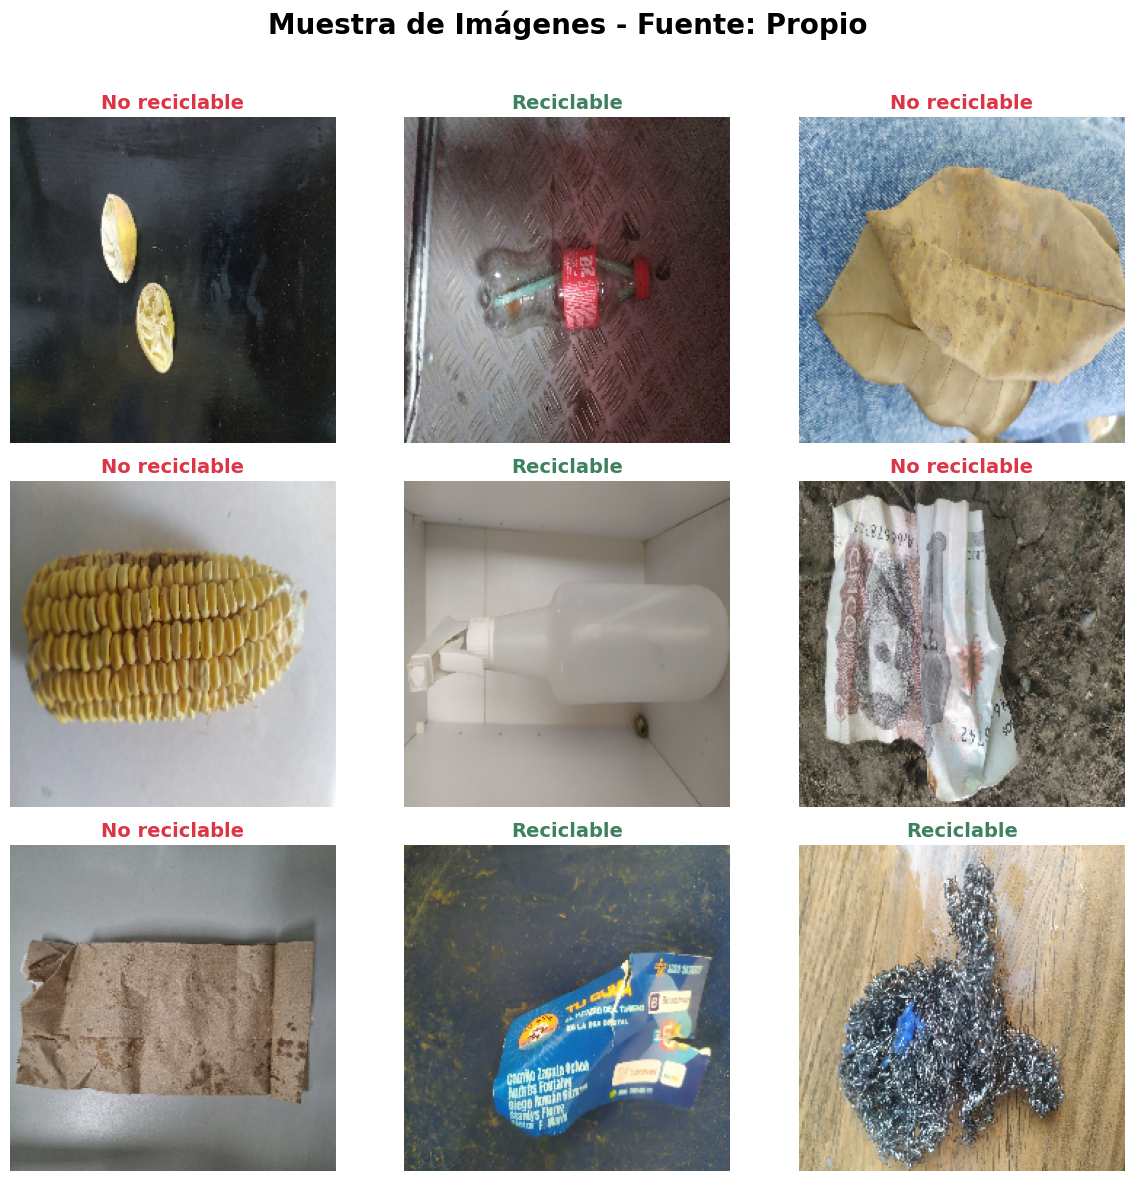

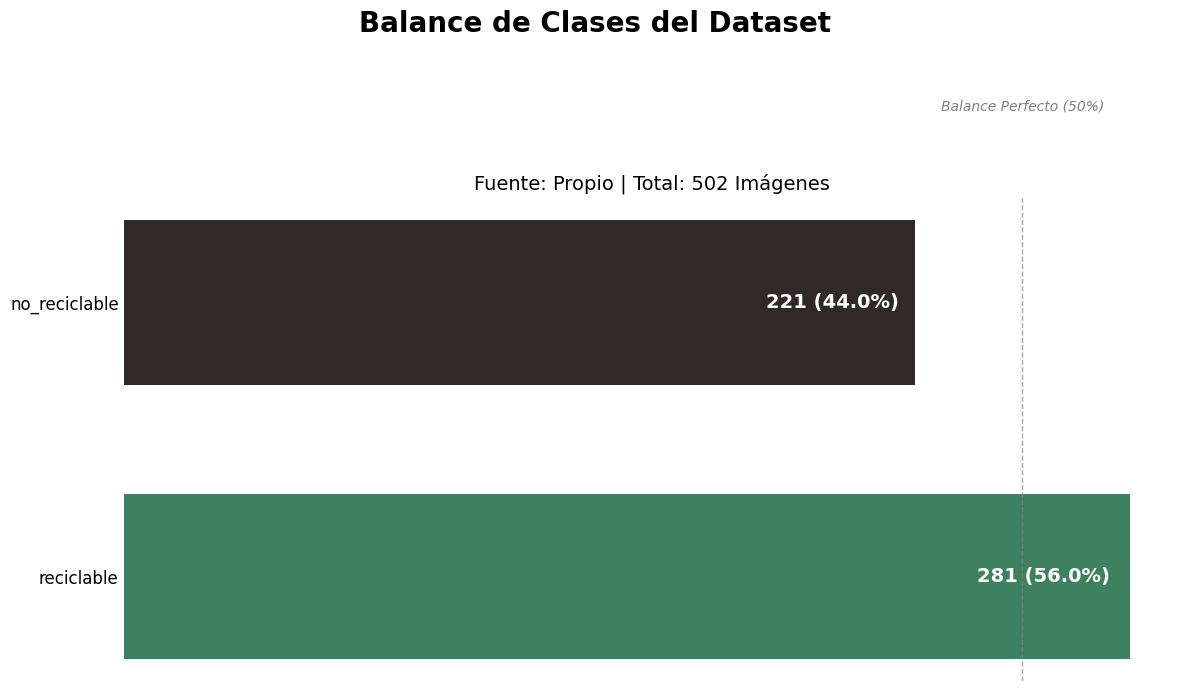


✅ Gráficas de EDA guardadas en la carpeta: /content/drive/MyDrive/Colab Notebooks/TalentoTech/Proyecto_VIREC/informe


In [4]:
# ====================================================================================
# @title (OPCIONAL) PASO 2.5: EJECUTAR ANÁLISIS EXPLORATORIO DE DATOS
# ====================================================================================

def generar_visualizaciones_eda():
    """
    Genera y guarda las gráficas de EDA (muestra de imágenes y balance de clases)
    para el dataset propio.
    """
    print("Iniciando Análisis Exploratorio de Datos...")

    # --- 1. Configuración de Rutas para el Informe ---
    ruta_eda = RUTA_DATASET_PROPIO # Hacemos el EDA sobre nuestro dataset principal
    ruta_informe = os.path.join(RUTA_BASE_PROYECTO, 'informe')
    os.makedirs(ruta_informe, exist_ok=True)

    # --- 2. Conteo de Clases  ---
    class_counts = {}
    total_images = 0
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(ruta_eda, split)
        if os.path.exists(split_path):
            for class_name in os.listdir(split_path):
                class_path = os.path.join(split_path, class_name)
                if os.path.isdir(class_path):
                    num_files = len(os.listdir(class_path))
                    class_counts[class_name] = class_counts.get(class_name, 0) + num_files
                    total_images += num_files

    if total_images == 0:
        print("No se encontraron imágenes. Saltando EDA.")
        return

    # --- 3. Generar y Guardar Gráficas ---

    # Lógica para la muestra de imágenes...
    img_size = (224, 224) # Asumiendo un tamaño de imagen por defecto
    ruta_train_eda = os.path.join(ruta_eda, 'train')
    if os.path.exists(ruta_train_eda) and os.listdir(ruta_train_eda):
        # HACK: Usamos un generador temporal para no afectar los generadores principales
        temp_ds = tf.keras.utils.image_dataset_from_directory(
            ruta_train_eda,
            labels='inferred',
            label_mode='binary',
            image_size=img_size,
            batch_size=9, # 9 para la cuadrícula de 3x3
            shuffle=True
        )
        class_names = temp_ds.class_names
        color_map = {class_names[0]: "#dc3545", class_names[1]: "#3E8160"} # Rojo para 'No reciclable', Verde para 'Reciclable'

        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        fig.suptitle(f'Muestra de Imágenes - Fuente: Propio', fontsize=20, weight='bold')

        for images, labels in temp_ds.take(1): # Tomamos un solo batch
            for i, ax in enumerate(axes.flat):
                if i < len(images):
                    # Extraer el nombre de la clase
                    label_index = int(labels[i][0])
                    class_name = class_names[label_index]

                    # Configurar color del borde
                    border_color = color_map.get(class_name, '#312829') # Color por defecto si hay más clases

                    # Mostrar la imagen
                    ax.imshow(images[i].numpy().astype("uint8"), cmap='gray' if images[i].shape[-1]==1 else None)
                    ax.set_title(
                        class_name.replace('_', ' ').capitalize(),
                        fontsize=14,
                        color=border_color,
                        weight='bold'
                    )
                    ax.axis("off")

                    # Añadir borde de color
                    for spine in ax.spines.values():
                        spine.set_edgecolor(border_color)
                        spine.set_linewidth(4)
                else:
                    # Ocultar ejes si no hay imagen
                    ax.axis("off")

        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # Guardar la figura
        ruta_grafica_muestra = os.path.join(ruta_informe, 'muestra_de_datos.png')
        plt.savefig(ruta_grafica_muestra, dpi=300, bbox_inches='tight')
        plt.show()

    # Lógica para el balance de clases...
    labels = sorted(class_counts.keys())
    counts = [class_counts[label] for label in labels]
    PALETA_COLORES = {"texto": "#312829", "primario": "#3E8160"}
    colors = [PALETA_COLORES['texto'], PALETA_COLORES['primario']]

    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.barh(labels, counts, color=colors, height=0.6)

    # Títulos
    fig.suptitle('Balance de Clases del Dataset', fontsize=20, weight='bold')
    ax.set_title(f'Fuente: Propio | Total: {total_images} Imágenes', fontsize=14)

    # Invertir eje Y para que la clase más común esté arriba
    ax.invert_yaxis()

    # Añadir etiquetas con conteo y porcentaje
    for bar in bars:
        width = bar.get_width()
        percentage = f'{(width / total_images) * 100:.1f}%'
        ax.text(
            width * 0.98,
            bar.get_y() + bar.get_height() / 2,
            f'{width} ({percentage})',
            ha='right',
            va='center',
            fontsize=14,
            color='white',
            weight='bold'
        )

    # Limpieza de estilo del gráfico
    for spine_pos in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine_pos].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.tick_params(axis='y', length=0, labelsize=12)

    # Línea de balance perfecto (si hay dos clases)
    if len(labels) == 2:
        ax.axvline(x=total_images / 2, color='gray', linestyle='--', linewidth=1, alpha=0.7)
        ax.text(total_images / 2, -0.7, 'Balance Perfecto (50%)', ha='center', color='gray', style='italic')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Guardar la figura
    ruta_grafica_balance = os.path.join(ruta_informe, 'balance_de_clases.png')
    plt.savefig(ruta_grafica_balance, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Gráficas de EDA guardadas en la carpeta: {ruta_informe}")

# --- Descomenta la siguiente línea para ejecutar el EDA ---
generar_visualizaciones_eda()


### **Ejecución del Pipeline de Entrenamiento Automatizado**
Esta celda es el motor principal del notebook. Al ejecutarla, orquestará todo el proceso:
1.  Buscará la próxima tarea `PENDIENTE` en la Hoja de Experimentos.
2.  Si encuentra una, cargará los datos y los parámetros correspondientes.
3.  Construirá, compilará y entrenará el modelo.
4.  Evaluará el rendimiento y generará todas las gráficas.
5.  Registrará los resultados finales en la Hoja de Experimentos y en el CSV local.

Si no hay tareas pendientes, el script simplemente lo informará y se detendrá.

In [3]:
# ====================================================================================
# @title PASO 4: EJECUTAR EL PRÓXIMO EXPERIMENTO DE LA COLA
# ====================================================================================

# --- 1. Cargar la Tarea ---
if 'hoja_experimentos' in locals() and hoja_experimentos:
    siguiente_tarea, fila_a_actualizar, headers = cargar_proxima_tarea(hoja_experimentos)
else:
    siguiente_tarea = None

if siguiente_tarea is not None:
    try:
        # --- 2. Cargar Parámetros del Experimento ---
        EXPERIMENT_ID = siguiente_tarea['experiment_id']
        MODELO_BASE = siguiente_tarea['modelo_base']
        LEARNING_RATE = float(str(siguiente_tarea['learning_rate']).replace(',', '.'))
        BATCH_SIZE = int(siguiente_tarea['batch_size'])
        EPOCHS = int(siguiente_tarea['epochs'])
        img_size_int = int(siguiente_tarea['img_size'])
        IMG_SIZE = (img_size_int, img_size_int)
        USE_AUGMENTATION = str(siguiente_tarea['use_augmentation']).strip().upper() == 'TRUE'
        USE_GRAYSCALE = str(siguiente_tarea['use_grayscale']).strip().upper() == 'TRUE'
        DATASET_SOURCE = siguiente_tarea['dataset_source'].lower()

        timestamp_folder = datetime.now(pytz.timezone(TIMEZONE)).strftime("%Y-%m-%d")
        NOMBRE_CARPETA_EXPERIMENTO = f"{timestamp_folder}_{EXPERIMENT_ID}"
        RUTA_RESULTADOS_EXPERIMENTO = os.path.join(RUTA_MODELOS, NOMBRE_CARPETA_EXPERIMENTO)
        os.makedirs(RUTA_RESULTADOS_EXPERIMENTO, exist_ok=True)
        aug_str = "aug-T" if USE_AUGMENTATION else "aug-F"; gray_str = "gray-T" if USE_GRAYSCALE else "gray-F"
        NOMBRE_ARCHIVO_MODELO = f"{timestamp_folder}_lr-{LEARNING_RATE}_bs-{BATCH_SIZE}_is-{img_size_int}_{aug_str}_{gray_str}_best.keras"
        checkpoint_path = os.path.join(RUTA_RESULTADOS_EXPERIMENTO, NOMBRE_ARCHIVO_MODELO)

        imprimir_configuracion(EXPERIMENT_ID, fila_a_actualizar, locals())

        # --- 3. Cargar y Preprocesar Datos ---
        color_mode = "grayscale" if USE_GRAYSCALE else "rgb"
        channels = 1 if USE_GRAYSCALE else 3
        # CORRECCIÓN: Recibimos class_names de la función
        train_ds, val_ds, test_ds, class_names = cargar_datasets(DATASET_SOURCE, IMG_SIZE, BATCH_SIZE, color_mode)

        # --- 4. Construir el Modelo ---
        model = construir_modelo(IMG_SIZE, channels, USE_AUGMENTATION, MODELO_BASE)

        # --- 5. Entrenar el Modelo ---
        history = entrenar_modelo(model, train_ds, val_ds, EPOCHS, LEARNING_RATE, checkpoint_path)

        # --- 6. Evaluar y Generar Artefactos ---
        resultados_metricas = evaluar_y_registrar(history, test_ds, checkpoint_path, EXPERIMENT_ID, class_names)

        # --- 7. Registrar Resultados Finales ---
        resultado_final = {**siguiente_tarea.to_dict(), **resultados_metricas}
        resultado_final['ruta_modelo_guardado'] = os.path.relpath(checkpoint_path, RUTA_BASE_PROYECTO)
        resultado_final['fecha_completado'] = datetime.now(pytz.timezone(TIMEZONE)).strftime('%Y-%m-%d %H:%M:%S')
        for key, val in resultado_final.items():
            if isinstance(val, float):
                resultado_final[key] = str(val).replace('.', ',')

        actualizar_registros(hoja_experimentos, fila_a_actualizar, headers, resultado_final)

    except Exception as e:
        # Manejo de errores
        print(f"❌ FALLO EL EXPERIMENTO: {EXPERIMENT_ID}. Razón: {e}")
        if 'hoja_experimentos' in locals() and hoja_experimentos:
            hoja_experimentos.update_cell(fila_a_actualizar, headers.index('status') + 1, 'FALLIDO')
            try:
                log_col_index = headers.index('log_error') + 1
                hoja_experimentos.update_cell(fila_a_actualizar, log_col_index, str(e))
            except ValueError: pass
        raise e

Buscando próxima tarea pendiente en la Hoja de Experimentos...
-> Tarea encontrada: 'Prueba_Parametros_Iniciales' en la fila 2.

          INICIANDO EXPERIMENTO: Prueba_Parametros_Iniciales (Fila 2)
--- Configuración Cargada ---
  - Fuente de Datos:         'propio'
  - Modelo Base:         'MobileNetV2'
  - Tasa de Aprendizaje (LR):  0.001
  - Tamaño de Lote (BS):       32
  - Épocas de Entrenamiento:   15
  - Tamaño de Imagen:          (224, 224)
  - Aumento de Datos:          True
  - Escala de Grises:          False

--- Rutas de Salida ---
  - Carpeta de Resultados:     2025-09-17_Prueba_Parametros_Iniciales
  - Archivo del Modelo:        2025-09-17_lr-0.001_bs-32_is-224_aug-T_gray-F_best.keras
Cargando datos para la fuente: 'propio'...
Found 401 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 51 files belonging to 2 classes.

Construyendo la arquitectura del modelo con base: 'MobileNetV2'...
✅ Modelo construido exitosamente.
   -> Se utilizaron los peso

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Iniciando entrenamiento por 15 épocas...
Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5145 - loss: 0.7984
Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to /content/drive/MyDrive/Colab Notebooks/TalentoTech/Proyecto_VIREC/modelos_entrenados/2025-09-17_Prueba_Parametros_Iniciales/2025-09-17_lr-0.001_bs-32_is-224_aug-T_gray-F_best.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 132s 8s/step - accuracy: 0.5179 - loss: 0.7940 - val_accuracy: 0.7600 - val_loss: 0.6020
Epoch 2/15
12/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6793 - loss: 0.6044

KeyboardInterrupt: 